In [1]:
import os
from pathlib import Path
from typing import Union
import pandas as pd
from scipy.signal import savgol_filter
from matplotlib.ticker import FuncFormatter
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
OUTPUTS_DIR = Path('outputs')

In [3]:
def readable_big_number(x: Union[int, float], precision=1, threshold=1) -> str:
    """
    >>> readable_big_number(1_000)
    '1k'
    >>> readable_big_number(20_123, precision=1)
    '20.1k'
    """
    if x == 0:
        return '0'

    was_negative = x < 0
    x = abs(x)

    if x < 10**3 * threshold:
        suffix = ''
    elif x < 10**6 * threshold:
        x /= float(10**3)
        suffix = 'k'
    elif x < 10**9 * threshold:
        x /= float(10**6)
        suffix = 'm'
    else:
        x /= float(10**9)
        suffix = 'b'

    fmt = '{:.' + str(precision) + 'f}'
    nr = fmt.format(x)

    nr = nr.lstrip('0')  # remove leading zeros
    if precision > 0:  # otherwise we strip useful zeros
        nr = nr.rstrip('0').rstrip('.')  # remove trailing zeros

    prefix = '-' if was_negative else ''
    return prefix + nr + suffix

In [4]:
def training_progress_static(dfs: [pd.DataFrame], window_sizes: [int], names: [str], bands=False):
    """ larger `window_size` => smoother curve """

    # sort them by the mean value so that the labels are in the same order as the lines
    for i, (df, window_size, name) in enumerate(zip(dfs, window_sizes, names)):
        if window_size % 2 == 0:
            window_size += 1  # must be odd
        
        color = f'C{i}'

        stats = df.groupby('episode').describe().reward
        mean = stats['mean']

        if bands:
            mins, maxs = stats['min'], stats['max']
            mean.plot(alpha=1, color=color)
            plt.fill_between(stats.index, mins, maxs, alpha=.1, color=color)
        elif window_size:
            ws = window_size
            if window_size > len(mean):
                ws = len(mean) // 2
                if ws % 2 == 0:
                    ws += 1  # must be odd
            smoothed = savgol_filter(mean, ws, polyorder=1)
            plt.plot(mean.index, smoothed, alpha=1, label=name, color=color)
            mean.plot(alpha=.25, label='', color=color)

    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: readable_big_number(x)))
    # plt.axhline(c='grey')

    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.legend()  # bottom right

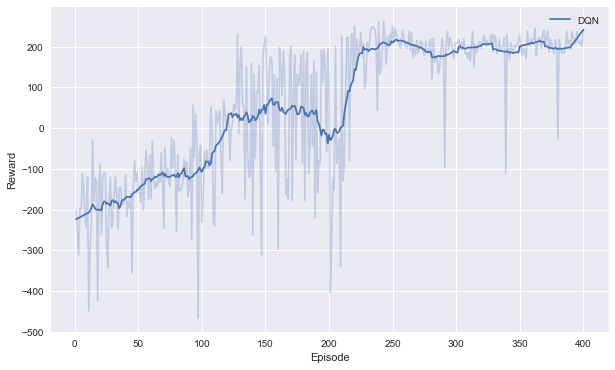

In [25]:
plt.figure(figsize=(10, 6))
df = pd.read_csv(OUTPUTS_DIR / 'vanilla dqn, oail params/lander-dqn-progress.csv')
training_progress_static([df], [20], ['DQN'])

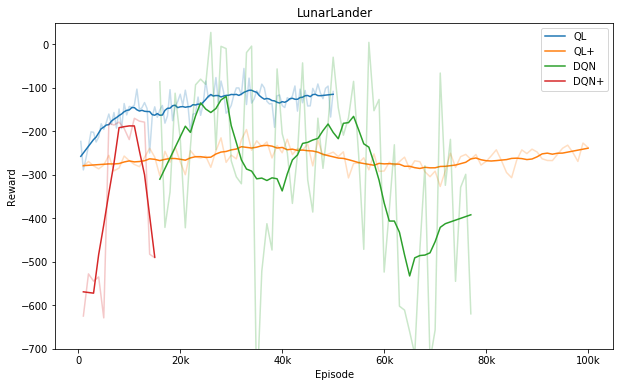

In [80]:
run_files = [f'lander-{a}-observed-progress.csv' for a in ['vanilla', 'extended', 'dqn', 'dqnp']]
dfs = [pd.read_csv(OUTPUTS_DIR / f) for f in run_files]

# keep best seed
dfs = [df[df.seed == df.groupby('seed').reward.max().sort_values().index[-1]] for df in dfs]

plt.figure(figsize=(10, 6))
training_progress_static(dfs, [10, 10, 10, 5], ['QL', 'QL+', 'DQN', 'DQN+'])
plt.ylim(-700, 50)
plt.title('LunarLander')

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/lander-comparison.{fmt}', format='png', bbox_inches='tight')
    
plt.show()

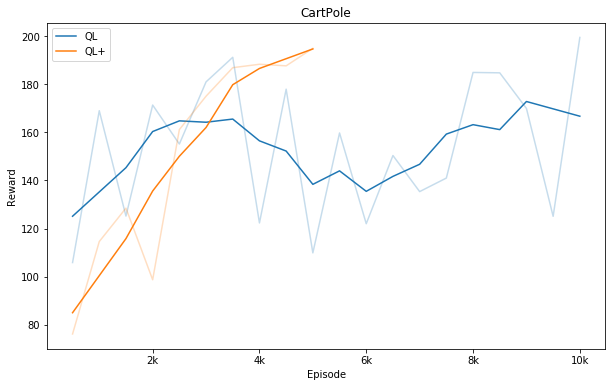

In [79]:
run_files = [f'pole-{a}-observed-progress.csv' for a in ['vanilla', 'extended']]
dfs = [pd.read_csv(OUTPUTS_DIR / f) for f in run_files]

# keep best seed
dfs = [df[df.seed == df.groupby('seed').reward.max().sort_values().index[-1]] for df in dfs]

plt.figure(figsize=(10, 6))
training_progress_static(dfs, [5, 5], ['QL', 'QL+'])
plt.title('CartPole')

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/pole-comparison.{fmt}', format='png', bbox_inches='tight')
    
plt.show()

---

In [71]:
run_name = 'lander-extended-observed'

In [72]:
progress_df = pd.read_csv(OUTPUTS_DIR / (run_name + '-progress.csv'), index_col=0)

In [74]:
progress_df = progress_df[progress_df.seed.isin([9, 8, 3])]

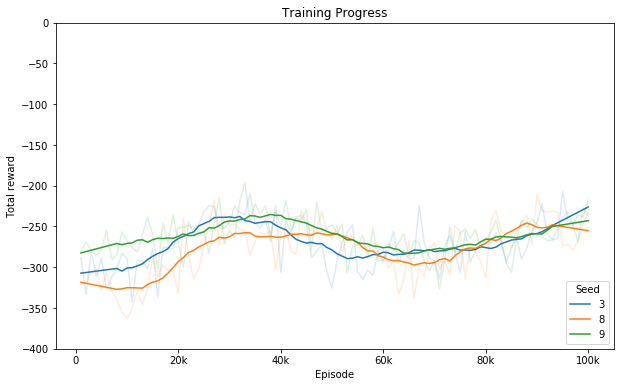

In [75]:
plt.figure(figsize=(10, 6))
training_progress_static(progress_df, window_size=15)
plt.ylim(-400, 0)

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/{run_name}.{fmt}', format='png', bbox_inches='tight')

---

In [8]:
config_fields = ['env', 'agent', 'state']

In [77]:
dfs = []

for fname in os.listdir(OUTPUTS_DIR):
    [*config, kind] = fname.split('-')
    if kind != 'runs.csv':
        continue

    df = pd.read_csv(OUTPUTS_DIR / fname, index_col=0)
    for name, value in zip(config_fields, config):
        df[name] = value
    
    dfs.append(df)
    
all_runs = pd.concat(dfs)

In [82]:
dfs = []

for fname in os.listdir(OUTPUTS_DIR):
    [*config, kind] = fname.split('-')
    if kind != 'progress.csv':
        continue

    df = pd.read_csv(OUTPUTS_DIR / fname, index_col=0)
    for name, value in zip(config_fields, config):
        df[name] = value
    
    dfs.append(df)
    
all_prog = pd.concat(dfs)

In [109]:
# usual time
all_runs[all_runs.state == 'observed'].pivot_table(
    index='agent',
    columns='env',
    values='time',
    aggfunc='median',
).applymap(lambda s: time.strftime("%H:%M:%S", time.gmtime(s)))

env,lander,pole
agent,,
extended,08:58:04,00:00:49
vanilla,07:19:09,00:00:51


In [94]:
# most reward
all_prog[all_prog.env == 'lander'].pivot_table(
    index='agent',
    columns='env',
    values='reward',
    aggfunc='max',
)

env,lander
agent,
extended,276.527604
vanilla,266.690916


In [127]:
# usual convergence
all_prog[all_prog.env == 'pole'].pivot_table(
    index='agent',
    columns='env',
    values='episode',
    aggfunc='median',
)

env,pole
agent,
extended,3000
vanilla,33000


In [124]:
all_prog[(all_prog.env == 'lander') & (all_prog.agent == 'vanilla') & (all_prog.episode > 45_000)].groupby('seed').reward.describe()

,count,mean,std,min,25%,50%,75%,max
seed,,,,,,,,
0,1000.0,-115.626096,149.368880,-635.064826,-210.554004,-120.100425,-57.912530,266.690916
1,1000.0,-119.913216,153.284553,-848.760968,-200.862406,-119.919566,-61.282562,257.201805


In [126]:
all_prog[(all_prog.env == 'lander') & (all_prog.agent == 'extended') & (all_prog.episode > 95_000)].groupby('seed').reward.describe()

,count,mean,std,min,25%,50%,75%,max
seed,,,,,,,,
0,500.0,-249.477076,172.456995,-724.691939,-371.680560,-237.480663,-142.444633,246.283646
1,500.0,-253.610924,157.402845,-755.175890,-365.647643,-249.243900,-148.468633,232.996595
2,500.0,-261.965978,154.963740,-675.553655,-372.521767,-265.637476,-165.952671,230.831975
3,500.0,-236.239279,155.079215,-695.362821,-353.761288,-225.671444,-129.207664,230.882804
4,500.0,-250.745618,168.664157,-1075.082784,-356.343304,-238.879618,-148.292968,241.628806
5,500.0,-232.175091,164.383330,-712.981174,-341.684749,-232.835749,-125.239259,241.338459
6,500.0,-245.309156,167.876517,-795.871704,-352.463667,-233.271974,-156.361355,249.157798
7,500.0,-247.967952,156.916383,-644.441426,-356.902217,-243.996664,-150.262024,240.367603
8,500.0,-259.501799,163.430300,-781.243926,-374.845319,-247.957740,-158.952457,241.550440


---

In [2]:
def exploration_decay(n_episodes, init, decay, min_val, label=None):
    """ Helps decide exploration parameters by visualizing the decay curve. """
    xs = list(range(n_episodes))
    ys = [init]

    for _ in xs[:-1]:
        # because of floating point errors, compute it iteratively instead of analytically
        ys.append(max(ys[-1] * decay, min_val))

    plt.plot(xs, ys, label=label)

#     plt.ylim(0, 1)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: readable_big_number(x)))
    plt.xlabel('Episode')

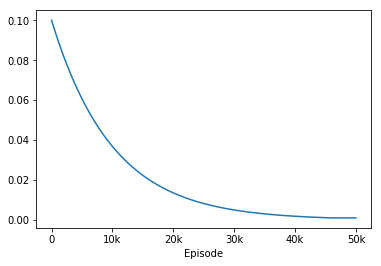

In [19]:
exploration_decay(50_000, .1, .9999, .001)